In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import os
import glob
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay

In [9]:
all_files = glob.glob(os.path.join('csv/', "*.csv"))
df = pd.concat((pd.read_csv(f, low_memory=False) for f in all_files))
df.columns = df.columns.str.lower()
df.columns = df.columns.str.replace('-', '_')
df.drop('unnamed: 64', axis=1, inplace=True)

# Turn dates into datetime.
date_cols = df.columns[df.columns.str.contains('date')]
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')

def original_sentence_format(x):
    try:
        year = int(x[:3])
        month = int(x[5:7]) / 12
        day = int(x[10:12]) / 365
        return year + month + day
    except:
        return 0

df['original_sentence'] = df.original_sentence.apply(original_sentence_format)
df['was_sentenced'] = (df.original_sentence >= 1) * 1
df['age'] = df.case_date.apply(lambda x: x.year) - df.birthdate.apply(lambda x: x.year)
df = df.dropna(subset='age')
df.offense_type.replace(df.offense_type.value_counts()[14:].index, 'None', inplace=True)
df['year'] = df.offense_date.apply(lambda x: x.year)

def format_decade(year):
    previous_decade = 1900
    for current_decade in range(1960, 2030, 10):
        if (year > previous_decade) and (year <= current_decade):
            return int(current_decade)
        previous_decade = current_decade
df['decade'] = df.year.apply(lambda x: format_decade(x))
df.reset_index(drop=True, inplace=True)

df = df[['was_sentenced', 'original_sentence', 'age', 'offense_type', 'race', 'sex', 'addr_zip_code', 'decade', ]]
df = pd.get_dummies(df,columns=['sex', 'race', 'offense_type', 'decade'], drop_first=True)

In [10]:
print(f'There are {df.addr_zip_code.nunique()} unique Zip Codes in the data')
df.addr_zip_code.value_counts()[:300]

There are 4747 unique Zip Codes in the data


78207    33319
0        30313
78237    17552
78228    16874
78210    15589
         ...  
76116       22
78722       22
78384       22
78736       22
77590       22
Name: addr_zip_code, Length: 300, dtype: int64

Use this website to extract zip code information: http://www.city-data.com/zips/78207.html

1st goal, predicting the time of the sentence (regression) - use subset of those who were sentenced.
2nd goal, categorical variable depending if they were sentenced or not. 

### Regression: How long are they sentenced for

In [22]:
y = df['original_sentence']
X = df[df.columns[2:]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
lasso = linear_model.Lasso(alpha=0.2)
lasso = lasso.fit(X_train,y_train)

In [23]:
lasso.score(X_test, y_test)

0.15996795045830436

In [24]:
lasso.coef_

array([-0.        , -0.        , -0.        ,  0.02310246, -0.        ,
       -0.        ,  0.        , -0.        ,  0.        , -0.        ,
       -0.        ,  0.        , -0.        , -0.        , -0.02824699,
        0.        , -0.        , -0.        ,  1.52879317,  0.32597424,
       -0.        ,  0.04176476, -0.64335801, -0.        , -0.07608304,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.13152157,  0.40770381,  0.47510155,  0.        , -0.0572151 ])

### Classification: Are they sentenced or not

In [35]:
X = df.drop(['target', 'addr_zip_code'], axis=1)
y = df.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
clf = LogisticRegression()
clf = clf.fit(X_train,y_train)

In [50]:
print(f'Classifier Score on Test Set {round(clf.score(X_test, y_test),3)}')

Classifier Score on Test Set 0.67


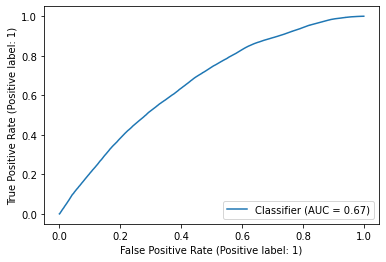

In [47]:
RocCurveDisplay.from_predictions(y_test, clf.decision_function(X_test));

<AxesSubplot:>

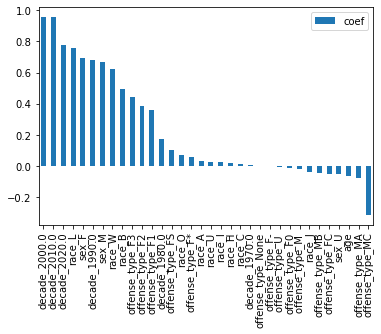

In [56]:
pd.DataFrame(clf.coef_.T, X.columns, columns=['coef']).sort_values(by='coef', ascending=False).plot.bar()

In [57]:
pd.DataFrame(clf.coef_.T, X.columns, columns=['coef']).sort_values(by='coef', ascending=False)

,coef
decade_2000.0,0.957517
decade_2010.0,0.954725
decade_2020.0,0.774692
race_L,0.759583
sex_F,0.696425
decade_1990.0,0.678942
sex_M,0.666590
race_W,0.624948
race_B,0.492812
offense_type_F3,0.441518
